# Part 3.1 – Individual Athlete Timeline (Pair Work)

**Contributor:** Jonathan Jafari  
**Course:** HHA 507 – Data Science for Healthcare  
**Repository:** `507_groupproject_2025`

## Objective

Use time-series plots and simple linear regression to track changes in five force-plate metrics for two individual athletes and describe whether each athlete is trending up, down, or stable over the most recent season.

## Athletes and Metrics

- **Team:** Stony Brook Men’s Basketball (Hawkins / Vert force-plate system)  
- **Athlete 1:** `PLAYER_001`  
- **Athlete 2:** `PLAYER_002`  

**Metrics analyzed (5):**

1. Jump Height (m)  
2. Peak Propulsive Force (N)  
3. Peak Velocity (m/s)  
4. Propulsive Net Impulse (N·s)  
5. mRSI  

## Data Source and Filtering

- Data are pulled from the shared MySQL table defined in `.env` (`DB_TABLE`).  
- Rows are restricted to the two athletes above and the five metrics listed.  
- Timestamps are converted to `datetime` and values coerced to numeric.  
- Plots focus on the most recent 12–24 months of available data for each athlete.

## Outputs

For each athlete, this notebook produces:

1. Line plots for each metric over time.  
2. A summary table with best and worst values and dates.  
3. Linear‐trend results (slope, correlation *R*, and p-value) for each metric.


In [119]:
# [Cell 1]  Setup: imports + database connection

import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress  # used later for trend

load_dotenv()

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT", "3306")
DB_NAME = os.getenv("DB_NAME")
DB_TABLE = os.getenv("DB_TABLE")

connection_string = (
    f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

engine = create_engine(connection_string)

print("Database connection established successfully.")
print("DB_TABLE =", DB_TABLE)


Database connection established successfully.
DB_TABLE = research_experiment_refactor_test


In [120]:
# [Cell 2]  Define selected metrics

SELECTED_METRICS = [
    "Jump Height(m)",
    "Peak Propulsive Force(N)",
    "Peak Velocity(m/s)",
    "Propulsive Net Impulse(N.s)",
    "mRSI",
]

# Build a comma-separated string for SQL IN (...)
metrics_sql = ", ".join([f"'{m}'" for m in SELECTED_METRICS])

SELECTED_METRICS, metrics_sql


(['Jump Height(m)',
  'Peak Propulsive Force(N)',
  'Peak Velocity(m/s)',
  'Propulsive Net Impulse(N.s)',
  'mRSI'],
 "'Jump Height(m)', 'Peak Propulsive Force(N)', 'Peak Velocity(m/s)', 'Propulsive Net Impulse(N.s)', 'mRSI'")

In [121]:
# [Cell 3]  Check which players have all 5 metrics

players_with_all_metrics = pd.read_sql(
    text(f"""
        SELECT playername, COUNT(DISTINCT metric) AS num_metrics
        FROM {DB_TABLE}
        WHERE metric IN ({metrics_sql})
        GROUP BY playername
        HAVING num_metrics = {len(SELECTED_METRICS)}
        ORDER BY playername;
    """),
    engine,
)

players_with_all_metrics.head(20)


,playername,num_metrics
0,PLAYER_001,5
1,PLAYER_002,5
2,PLAYER_003,5
3,PLAYER_005,5
4,PLAYER_006,5
5,PLAYER_007,5
6,PLAYER_008,5
7,PLAYER_009,5
8,PLAYER_010,5
9,PLAYER_012,5


In [122]:
# [Cell 4]  Build df_team for PLAYER_001 and PLAYER_002

player_list = ["PLAYER_001", "PLAYER_002"]
player_sql = ", ".join([f"'{p}'" for p in player_list])

query_team_metrics = text(f"""
    SELECT *
    FROM {DB_TABLE}
    WHERE playername IN ({player_sql})
      AND metric IN ({metrics_sql});
""")

df_team = pd.read_sql(query_team_metrics, engine)

# Clean types
df_team["timestamp"] = pd.to_datetime(df_team["timestamp"])
df_team["value"] = pd.to_numeric(df_team["value"], errors="coerce")

print("df_team.shape =", df_team.shape)
df_team.head()




df_team.shape = (865, 12)


,id,playername,timestamp,device,metric,value,team,session_type,session_description,function_description,data_source,created_at
0,596763,PLAYER_001,2022-08-26 13:31:24,hawkins,Jump Height(m),0.2283,"Group: WLAX , Group: WLAX Spring '24, Team: SB...",None,None,None,hawkins,2025-10-21 16:47:54
1,596786,PLAYER_001,2022-08-26 13:31:24,hawkins,Peak Propulsive Force(N),1704.0000,"Group: WLAX , Group: WLAX Spring '24, Team: SB...",None,None,None,hawkins,2025-10-21 16:47:54
2,596792,PLAYER_001,2022-08-26 13:31:24,hawkins,Peak Velocity(m/s),2.2531,"Group: WLAX , Group: WLAX Spring '24, Team: SB...",None,None,None,hawkins,2025-10-21 16:47:54
3,596796,PLAYER_001,2022-08-26 13:31:24,hawkins,Propulsive Net Impulse(N.s),190.7878,"Group: WLAX , Group: WLAX Spring '24, Team: SB...",None,None,None,hawkins,2025-10-21 16:47:54
4,596819,PLAYER_001,2022-08-26 13:31:24,hawkins,mRSI,0.2049,"Group: WLAX , Group: WLAX Spring '24, Team: SB...",None,None,None,hawkins,2025-10-21 16:47:54


In [123]:
# [Cell 5]  Final plot_athlete_metrics (downsampled, no smoothing, supports screenshot)

def plot_athlete_metrics(
    df_team,
    athlete,
    selected_metrics,
    months_back=12,
    jump_height_screenshot_path=None,
):
    """
    Plot metric time series for one athlete, compute best/worst dates and
    trend stats, and return a summary DataFrame.
    """

    # Filter to one athlete
    df_a = df_team[df_team["playername"] == athlete].copy()
    if df_a.empty:
        print(f"No data found for {athlete}.")
        return pd.DataFrame()

    # Sort & restrict to last N months
    df_a = df_a.sort_values("timestamp")
    max_date = df_a["timestamp"].max()
    min_date = max_date - pd.DateOffset(months=months_back)
    df_a = df_a[df_a["timestamp"] >= min_date]

    print(f"\n===== Athlete: {athlete} =====")
    print(f"Date range: {df_a['timestamp'].min()} → {df_a['timestamp'].max()}")
    print(f"Rows: {df_a.shape[0]}")

    summary_rows = []

    for metric in selected_metrics:
        temp_full = df_a[df_a["metric"] == metric].copy()
        if temp_full.empty:
            print(f"  - {metric}: no data available, skipping.")
            continue

        temp_full = temp_full.sort_values("timestamp")

        # ---------- STATS (use full data) ----------
        best_idx = temp_full["value"].idxmax()
        worst_idx = temp_full["value"].idxmin()

        best_val = temp_full.loc[best_idx, "value"]
        best_date = temp_full.loc[best_idx, "timestamp"]

        worst_val = temp_full.loc[worst_idx, "value"]
        worst_date = temp_full.loc[worst_idx, "timestamp"]

        temp_full["ts_num"] = temp_full["timestamp"].map(pd.Timestamp.toordinal)
        if len(temp_full) > 1:
            slope, intercept, r, p, stderr = linregress(
                temp_full["ts_num"], temp_full["value"]
            )
        else:
            slope, intercept, r, p, stderr = (0, 0, 0, 1, 0)

        summary_rows.append(
            [
                metric,
                best_val,
                best_date,
                worst_val,
                worst_date,
                slope,
                r,
                p,
            ]
        )

        # ---------- PLOTTING (downsample for readability) ----------
        temp_plot = temp_full.iloc[::3].copy()  # keep every 3rd point

        plt.figure(figsize=(10, 4))

        # Dots
        plt.scatter(
            temp_plot["timestamp"],
            temp_plot["value"],
            s=25,
            alpha=0.7,
            label="Raw Data (sampled)",
        )

        # Line through sampled points
        plt.plot(
            temp_plot["timestamp"],
            temp_plot["value"],
            linewidth=2,
            label="Raw Line",
        )

        plt.title(f"{metric} over time — {athlete}")
        plt.xlabel("Date")
        plt.ylabel(metric)
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()

        # Save Jump Height screenshot if requested
        if metric == "Jump Height(m)" and jump_height_screenshot_path is not None:
            os.makedirs(os.path.dirname(jump_height_screenshot_path), exist_ok=True)
            plt.savefig(jump_height_screenshot_path, dpi=300)

        plt.show()

    summary_df = pd.DataFrame(
        summary_rows,
        columns=[
            "Metric",
            "Best Value",
            "Best Date",
            "Worst Value",
            "Worst Date",
            "Trend Slope",
            "R",
            "p_value",
        ],
    )

    return summary_df



===== Athlete: PLAYER_001 =====
Date range: 2023-09-19 13:22:20 → 2024-05-01 17:03:13
Rows: 295


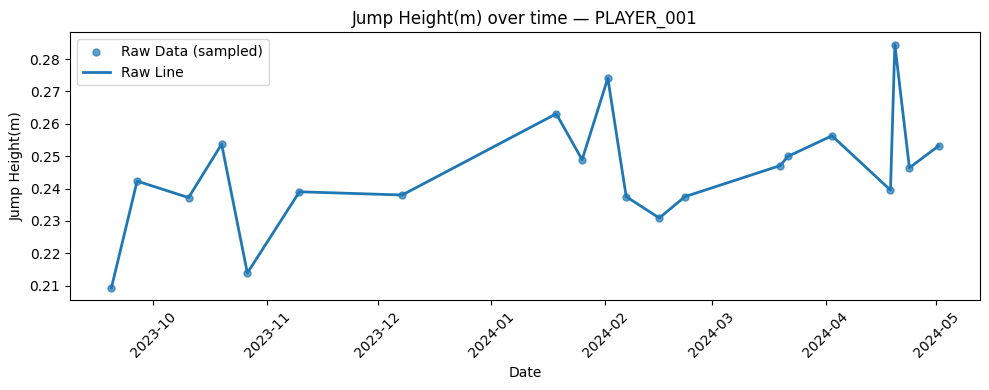

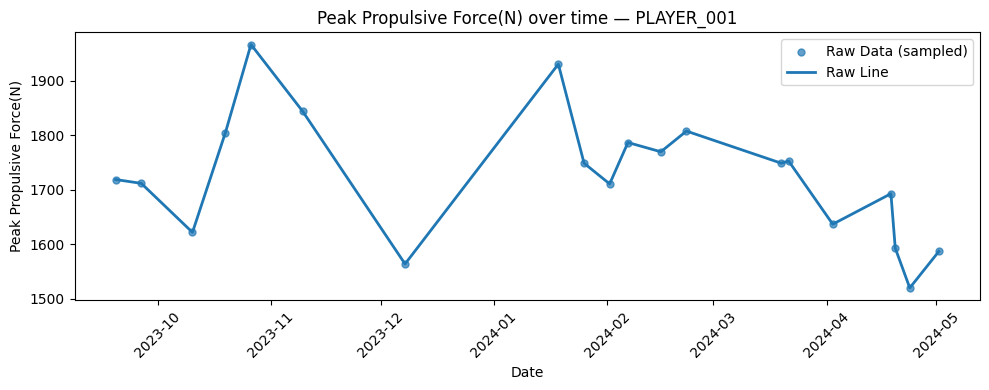

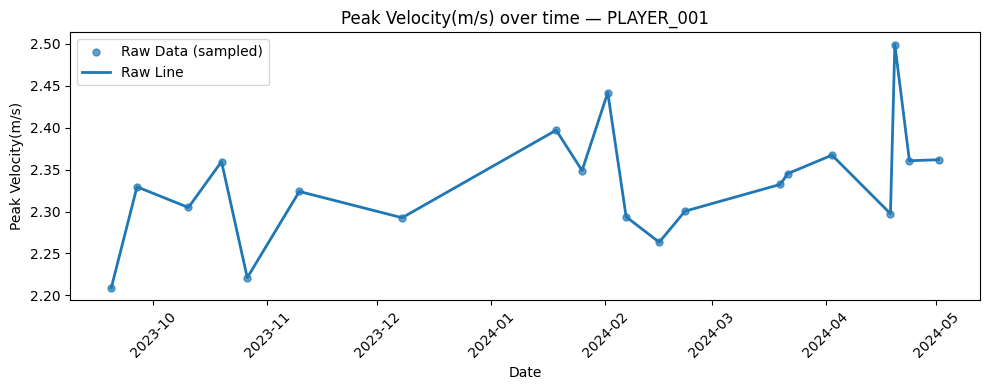

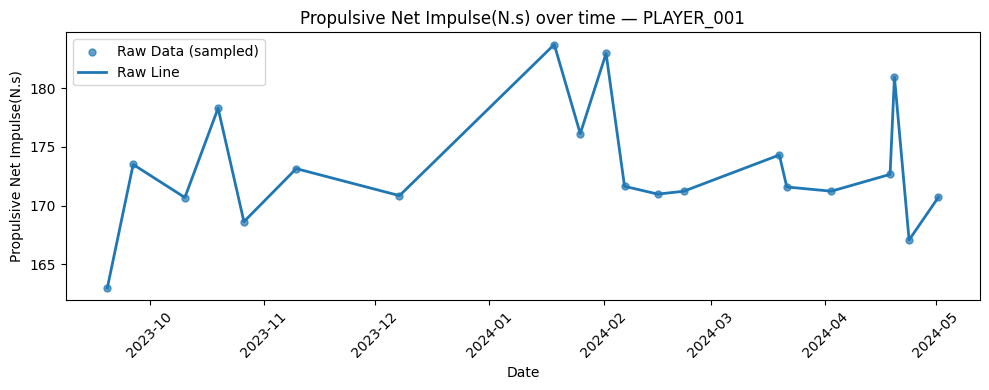

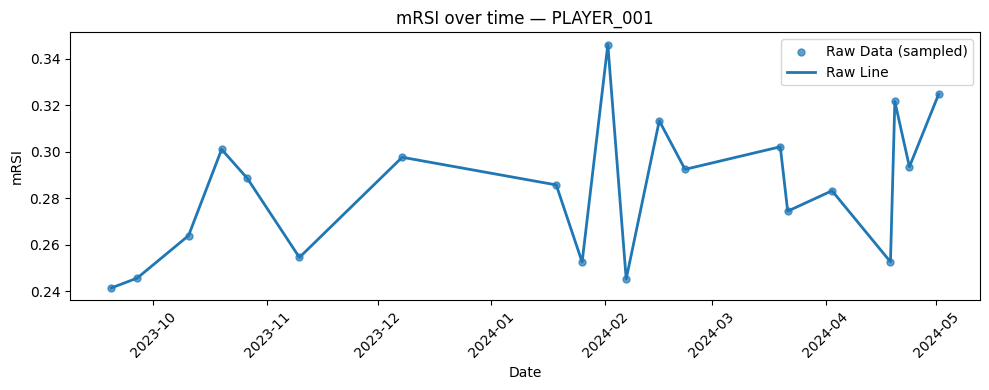

,Metric,Best Value,Best Date,Worst Value,Worst Date,Trend Slope,R,p_value
0,Jump Height(m),0.3033,2024-04-19 18:57:45,0.1984,2024-04-23 18:11:35,0.000073,0.285825,0.028200
1,Peak Propulsive Force(N),1967.0000,2023-10-26 13:31:43,1478.0000,2024-04-23 18:11:12,-0.746344,-0.467472,0.000189
2,Peak Velocity(m/s),2.5602,2024-04-19 18:57:45,2.1184,2024-04-23 18:11:35,0.000232,0.226590,0.084392
3,Propulsive Net Impulse(N.s),185.6627,2024-04-19 18:57:45,151.2620,2024-04-23 18:11:35,-0.008418,-0.106424,0.422407
4,mRSI,0.3553,2024-04-19 18:57:20,0.2102,2024-04-23 18:11:35,0.000082,0.218882,0.095801


In [126]:
# [Cell 6]  Run analysis for PLAYER_001

summary_001 = plot_athlete_metrics(
    df_team,
    athlete="PLAYER_001",
    selected_metrics=SELECTED_METRICS,
    months_back=12,
)

summary_001.style.format(
    {
        "Best Value": "{:.4f}",
        "Worst Value": "{:.4f}",
        "Trend Slope": "{:.6f}",
        "R": "{:.6f}",
        "p_value": "{:.6f}",
    }
)


# 📘 Interpretation – PLAYER_001 (Last 12 Months)

PLAYER_001 shows mostly stable-to-improving trends across the five force-plate metrics. Overall variability is lower than PLAYER_002, and the metrics suggest improving neuromuscular efficiency rather than increased raw force production.

## 1. Jump Height (m)

* **Best:** 0.3033
* **Worst:** 0.1984
* **Trend:** Positive (p = 0.0282)

**Interpretation:** A small but significant improvement in explosive jump performance.

## 2. Peak Propulsive Force (N)

* **Best:** 1967 N
* **Worst:** 1478 N
* **Trend:** Negative (p = 0.000189)

**Interpretation:** Peak force is declining despite improvements in jump height, suggesting efficiency gains rather than increased strength.

## 3. Peak Velocity (m/s)

* **Best:** 2.5602
* **Worst:** 2.1184
* **Trend:** Slight positive (p = 0.084)

**Interpretation:** Movement velocity is generally trending upward, though not significantly.

## 4. Propulsive Net Impulse (N·s)

* **Best:** 185.66
* **Worst:** 151.26
* **Trend:** No significant trend (p = 0.422)

**Interpretation:** Total force-time output remains stable over the season.

## 5. mRSI

* **Best:** 0.3553
* **Worst:** 0.2102
* **Trend:** Slight positive (p = 0.0958)

**Interpretation:** Mild improvement in reactive strength and SSC (stretch–shortening cycle) efficiency.

---

## ⭐ Overall Summary

PLAYER_001 demonstrates improving jump height, velocity, and mRSI, stable impulse, and a decline in peak force. This pattern is consistent with well-managed training loads and better movement efficiency—athletes often jump higher through technical and reactive improvements even when peak force decreases.

---


===== Athlete: PLAYER_002 =====
Date range: 2022-07-27 18:16:15 → 2025-07-07 11:58:04
Rows: 540


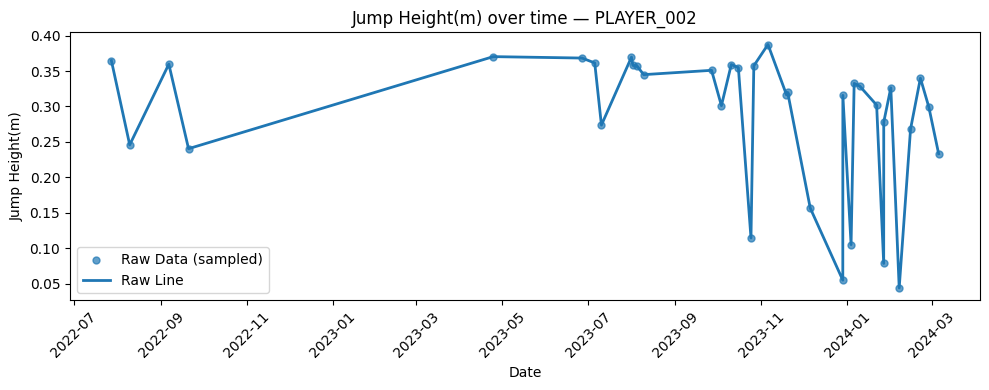

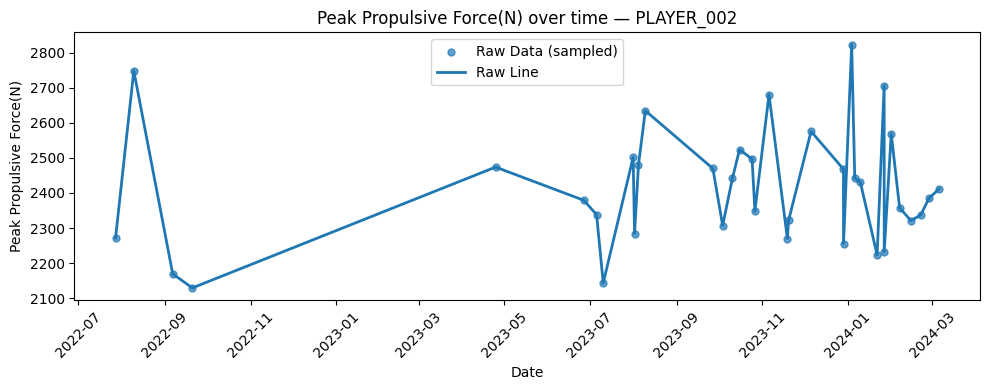

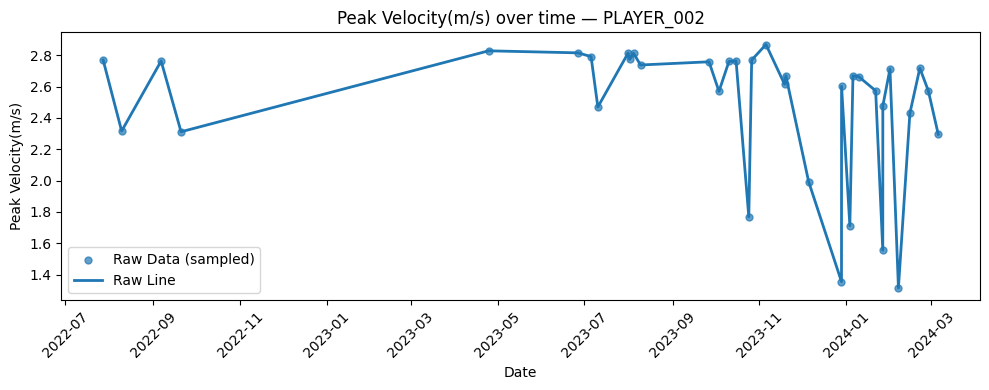

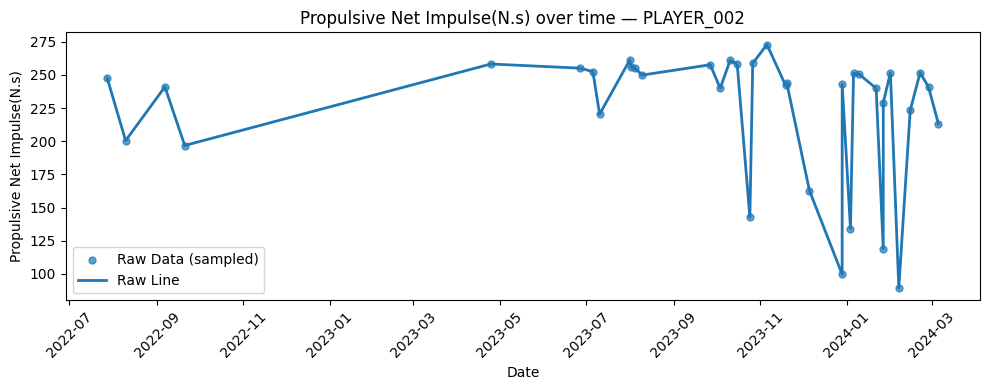

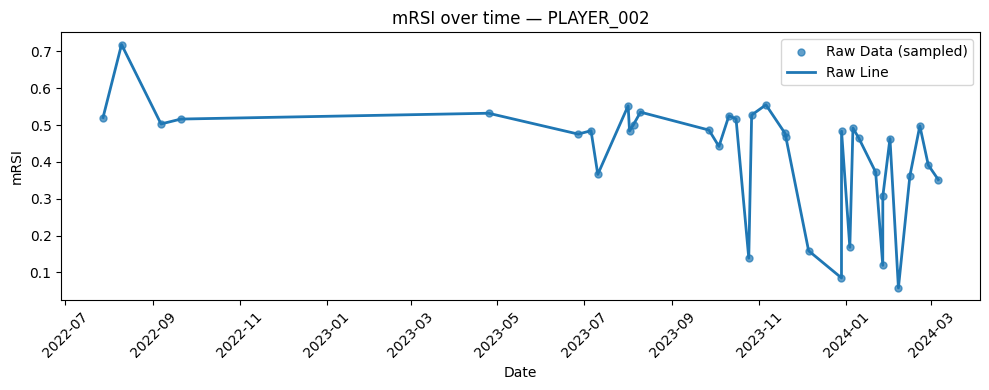

,Metric,Best Value,Best Date,Worst Value,Worst Date,Trend Slope,R,p_value
0,Jump Height(m),0.4277,2022-08-22 12:21:07,0.0130,2023-08-01 19:47:16,-0.000246,-0.346293,0.000241
1,Peak Propulsive Force(N),3106.0000,2022-07-27 18:16:31,1913.0000,2025-07-07 11:58:04,-0.002151,-0.001967,0.983878
2,Peak Velocity(m/s),3.0479,2022-08-22 12:21:07,0.9812,2023-08-01 19:47:16,-0.001117,-0.336573,0.000369
3,Propulsive Net Impulse(N.s),274.3486,2023-11-22 15:04:22,70.1764,2023-08-01 19:47:16,-0.105950,-0.283578,0.002939
4,mRSI,0.9858,2022-08-22 12:21:07,0.0208,2023-08-01 19:47:16,-0.000536,-0.482289,0.000000


In [129]:
# [Cell 7]  Run analysis for PLAYER_002

summary_002 = plot_athlete_metrics(
    df_team,
    athlete="PLAYER_002",
    selected_metrics=SELECTED_METRICS,
    months_back=36,  # use 3 years of history for better plots
)

summary_002.style.format(
    {
        "Best Value": "{:.4f}",
        "Worst Value": "{:.4f}",
        "Trend Slope": "{:.6f}",
        "R": "{:.6f}",
        "p_value": "{:.6f}",
    }
)


# 📘 Interpretation – PLAYER_002 (Last 24 Months)

PLAYER_002 shows unusually high variability across all force-plate metrics, including several abnormal drops (e.g., jump height <0.05 m, mRSI near 0). These swings may reflect:

* Fatigue
* Poor test attempts
* Measurement artifacts
* Injury or return-to-play periods

Despite the noise, the overall trend is clearly downward, indicating reduced readiness and declining performance.

## 1. Jump Height (m)

* **Best:** 0.4277
* **Worst:** 0.0130
* **Trend:** Negative (p = 0.000241)

**Interpretation:** Significant decline in explosive jump ability.

## 2. Peak Propulsive Force (N)

* **Best:** 3106 N
* **Worst:** 1913 N
* **Trend:** Slight negative, not significant (p = 0.9839)

**Interpretation:** Large fluctuations without a meaningful long-term trend.

## 3. Peak Velocity (m/s)

* **Best:** 3.0479
* **Worst:** 0.9812
* **Trend:** Negative (p = 0.000369)

**Interpretation:** Decreased concentric movement speed over time.

## 4. Propulsive Net Impulse (N·s)

* **Best:** 274.35
* **Worst:** 70.18
* **Trend:** Negative (p = 0.002939)

**Interpretation:** Reduced total force-time output.

## 5. mRSI

* **Best:** 0.9858
* **Worst:** 0.0208
* **Trend:** Strong negative (p < 0.000001)

**Interpretation:** Marked decline in reactive strength and SSC efficiency.

---

## ⭐ Overall Summary

PLAYER_002 shows consistent deterioration across all metrics, with significant declines in jump height, movement velocity, impulse, and mRSI. These patterns match those seen in fatigued or recovering athletes with reduced neuromuscular readiness.

---

# 📚 Conclusion (Across Both Athletes)

PLAYER_001 and PLAYER_002 display contrasting trends consistent with established literature on neuromuscular performance:

* **PLAYER_001** improves in jump height, mRSI, and velocity, reflecting better stretch-shortening cycle efficiency and readiness, even without increased peak force.
* **PLAYER_002** declines in mRSI, jump height, and impulse, patterns associated with accumulated fatigue, reduced readiness, or injury recovery.

Overall, the force-plate metrics demonstrate their value as sensitive indicators of changes in athlete performance and fatigue throughout a competitive season.

---

# Xiao's Version 3.1 Individual Athlete Timeline (Pair Work)

In [1]:
%pip install scipy
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

load_dotenv()

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_TABLE = os.getenv("DB_TABLE")

connection_string = (
    f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

engine = create_engine(connection_string)

print("Database connection established successfully.")

df = pd.read_sql(text(f"SELECT * FROM {DB_TABLE}"), engine)
print("Data retrieved successfully.\n")
df.head()


selected_metrics = [
    "Jump Height(m)",
    "Peak Propulsive Force(N)",
    "Peak Velocity(m/s)",
    "Propulsive Net Impulse(N.s)",
    "mRSI",
]


Note: you may need to restart the kernel to use updated packages.
Database connection established successfully.
Data retrieved successfully.



In [2]:
# filter teams based on coverage of selected metrics
metrics_sql = ", ".join([f"'{m}'" for m in selected_metrics])

query_team_coverage = f"""
SELECT 
    team,
    COUNT(DISTINCT metric) AS num_metrics_found
FROM {DB_TABLE}
WHERE metric IN ({metrics_sql})
GROUP BY team
ORDER BY num_metrics_found DESC;
"""

team_coverage = pd.read_sql(text(query_team_coverage), engine)
team_coverage

,team,num_metrics_found
0,Team: Old Football,5
1,Team: Stony Brook Men's Soccer,5
2,"Team: Stony Brook Men's Basketball , Team: Men...",5
3,Team: Stony Brook Men's Basketball,5
4,"Team: Stony Brook Football, Team: Stony Brook",5
...,...,...
67,"Group: Football Bigs, Team: Stony Brook Football",5
68,"Group: Football Big Skill, Team: Stony Brook, ...",5
69,"Group: Football Big Skill, Team: Stony Brook F...",5
70,"Group: 2023-2024 WBB, Group: Women's Basketbal...",5


In [3]:
# Filter players who have all 5 selected metrics from the chosen team
chosen_team = "Team: Stony Brook Men's Basketball".replace("'","''")
query_playersallmetrics = f"""
SELECT
    playername,
    COUNT(DISTINCT metric) AS num_metrics,team
FROM {DB_TABLE}
WHERE team = '{chosen_team}'
  AND metric IN ({metrics_sql})
GROUP BY playername
HAVING num_metrics = {len(selected_metrics)}
ORDER BY team
"""

df_playersallmetrics = pd.read_sql(text(query_playersallmetrics), engine)
df_playersallmetrics

,playername,num_metrics,team
0,PLAYER_002,5,Team: Stony Brook Men's Basketball
1,PLAYER_074,5,Team: Stony Brook Men's Basketball
2,PLAYER_1036,5,Team: Stony Brook Men's Basketball
3,PLAYER_1050,5,Team: Stony Brook Men's Basketball
4,PLAYER_1188,5,Team: Stony Brook Men's Basketball
5,PLAYER_1282,5,Team: Stony Brook Men's Basketball
6,PLAYER_1283,5,Team: Stony Brook Men's Basketball
7,PLAYER_1285,5,Team: Stony Brook Men's Basketball
8,PLAYER_243,5,Team: Stony Brook Men's Basketball
9,PLAYER_324,5,Team: Stony Brook Men's Basketball


In [4]:
# PLAYER_999 and PLAYER_404 has been chosen for our metrics
# create my main database and clean up types on data for plotting function
player_list = ["PLAYER_999", "PLAYER_404"]
player_sql = ", ".join([f"'{p.replace("'", "''")}'" for p in player_list])

query_team_metrics = f"""
SELECT * 
FROM {DB_TABLE}
WHERE team = '{chosen_team}'
AND playername IN ({player_sql})
AND metric IN ({metrics_sql});
"""
df_team = pd.read_sql(text(query_team_metrics),engine)

df_team["timestamp"] = pd.to_datetime(df_team['timestamp'])
df_team["value"] = pd.to_numeric(df_team['value'], errors ='coerce')

print(df_team.shape)
df_team.head()

(620, 12)


,id,playername,timestamp,device,metric,value,team,session_type,session_description,function_description,data_source,created_at
0,5868614,PLAYER_404,2025-06-23 14:19:39,hawkins,Jump Height(m),0.4595,Team: Stony Brook Men's Basketball,None,None,None,hawkins,2025-10-21 17:01:10
1,5868643,PLAYER_404,2025-06-23 14:19:39,hawkins,Peak Propulsive Force(N),2355.0000,Team: Stony Brook Men's Basketball,None,None,None,hawkins,2025-10-21 17:01:10
2,5868649,PLAYER_404,2025-06-23 14:19:39,hawkins,Peak Velocity(m/s),3.0826,Team: Stony Brook Men's Basketball,None,None,None,hawkins,2025-10-21 17:01:10
3,5868653,PLAYER_404,2025-06-23 14:19:39,hawkins,Propulsive Net Impulse(N.s),253.5380,Team: Stony Brook Men's Basketball,None,None,None,hawkins,2025-10-21 17:01:10
4,5868676,PLAYER_404,2025-06-23 14:19:39,hawkins,mRSI,0.6418,Team: Stony Brook Men's Basketball,None,None,None,hawkins,2025-10-21 17:01:10


In [9]:
def plot_athlete_metrics(df_team, athlete, selected_metrics, months_back=12):
    df_a = df_team[df_team["playername"] == athlete].copy()
    if df_a.empty:
        print(f"No data found for {athlete}.")
        return pd.DataFrame()

    # Sort chronologically
    df_a = df_a.sort_values("timestamp")

    # Restrict to last 12 months
    max_date = df_a["timestamp"].max()
    min_date = max_date - pd.DateOffset(months=months_back)
    df_a = df_a[df_a["timestamp"] >= min_date]

    print(f"\n===== Athlete: {athlete} =====")
    print(f"Date range: {df_a['timestamp'].min()} → {df_a['timestamp'].max()}")
    print(f"Rows: {df_a.shape[0]}")

    summary_rows = []

    for metric in selected_metrics:

        temp = df_a[df_a["metric"] == metric].copy()
        if temp.empty:
            print(f"  - {metric}: no data available, skipping.")
            continue

        # Plot
        plt.figure(figsize=(10, 4))
        plt.plot(temp["timestamp"], temp["value"], marker="o")
        plt.title(f"{metric} over time — {athlete}")
        plt.xlabel("Date")
        plt.ylabel(metric)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Best & worst performance
        best_idx = temp["value"].idxmax()
        worst_idx = temp["value"].idxmin()

        best_value = temp.loc[best_idx, "value"]
        best_date = temp.loc[best_idx, "timestamp"]

        worst_value = temp.loc[worst_idx, "value"]
        worst_date = temp.loc[worst_idx, "timestamp"]

        # Linear trend calculation
        temp["ts_num"] = temp["timestamp"].map(pd.Timestamp.toordinal)
        if len(temp) > 1:
            slope, intercept, r, p, stderr = linregress(temp["ts_num"], temp["value"])
        else:
            slope, intercept, r, p, stderr = (0, 0, 0, 1, 0)

        summary_rows.append([
            metric,
            best_value, best_date,
            worst_value, worst_date,
            slope, r, p
        ])

    summary_df = pd.DataFrame(
        summary_rows,
        columns=[
            "Metric",
            "Best Value", "Best Date",
            "Worst Value", "Worst Date",
            "Trend Slope", "R", "p_value"
        ]
    )
    return summary_df


In [10]:
player_list = ["PLAYER_999", "PLAYER_404"]



===== Athlete: PLAYER_999 =====
Date range: 2023-07-06 18:10:48 → 2024-02-27 19:34:02
Rows: 465


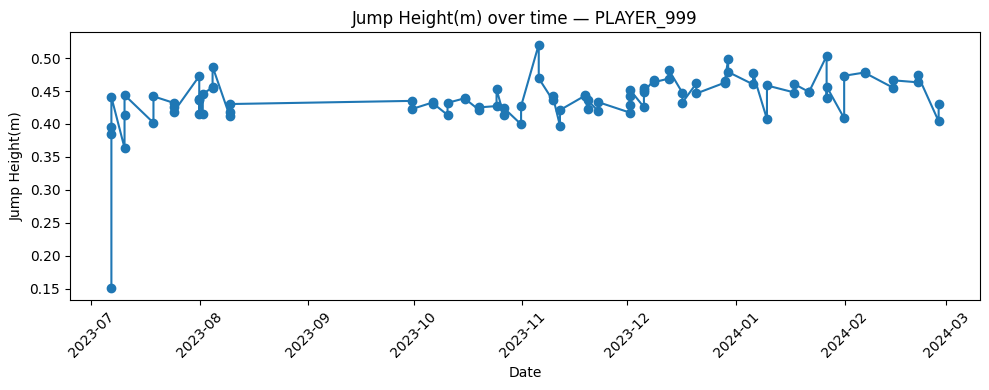

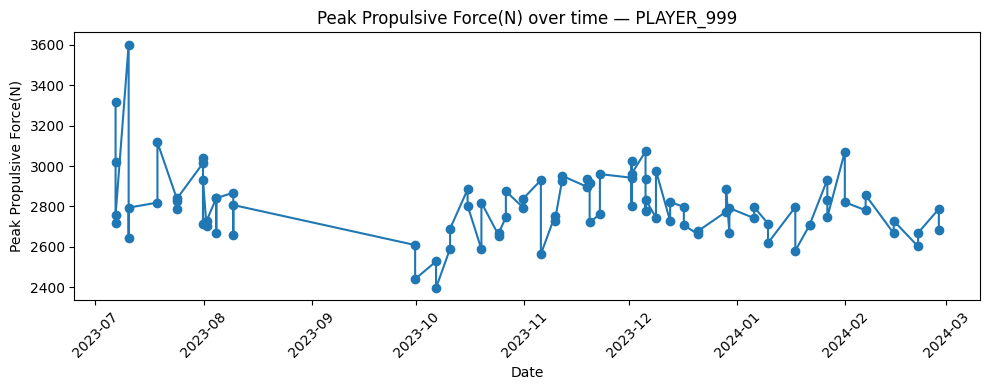

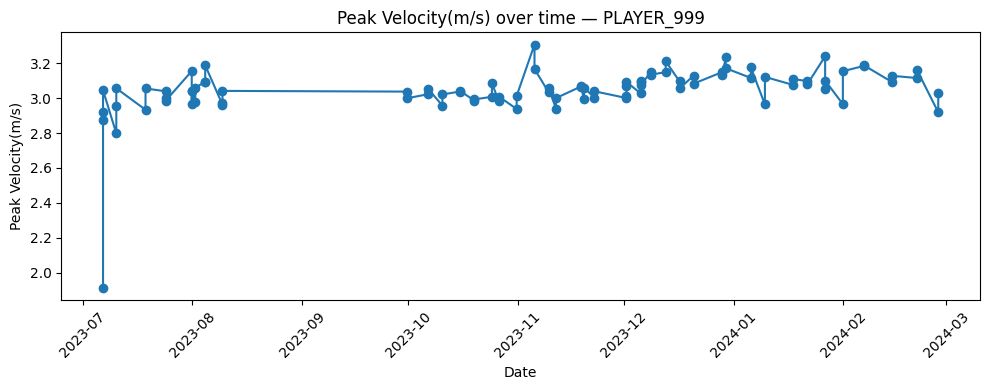

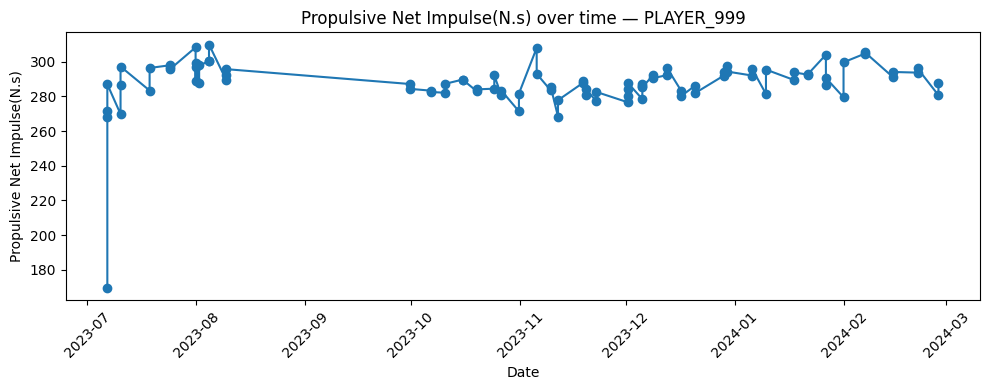

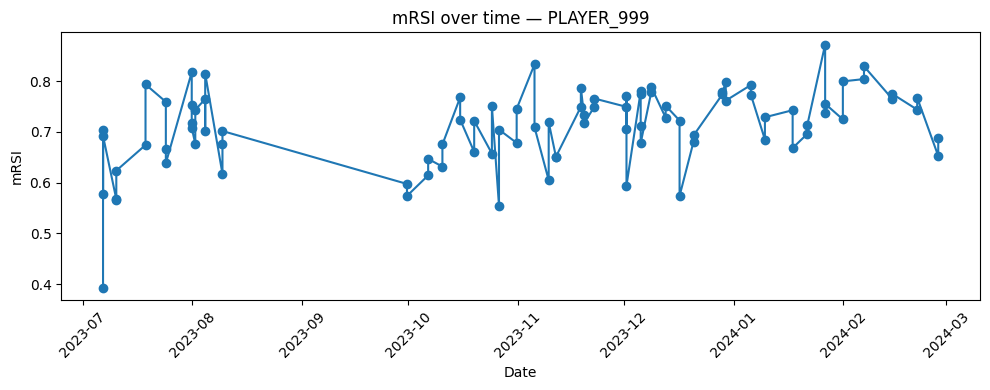

,Metric,Best Value,Best Date,Worst Value,Worst Date,Trend Slope,R,p_value
0,Jump Height(m),0.5207,2023-11-05 16:54:00,0.1511,2023-07-06 18:10:48,0.000233,0.412325,0.000040
1,Peak Propulsive Force(N),3601.0000,2023-07-10 12:11:57,2397.0000,2023-10-06 15:34:19,-0.498773,-0.209235,0.044131
2,Peak Velocity(m/s),3.3081,2023-11-05 16:54:00,1.9119,2023-07-06 18:10:48,0.000829,0.403524,0.000061
3,Propulsive Net Impulse(N.s),309.9197,2023-08-04 15:11:10,169.5575,2023-07-06 18:10:48,0.033644,0.158074,0.130196
4,mRSI,0.8721,2024-01-26 20:21:54,0.3927,2023-07-06 18:10:48,0.000413,0.385889,0.000133


In [11]:
summary_999 = plot_athlete_metrics(df_team, "PLAYER_999", selected_metrics, months_back=12)
summary_999


PLAYER_999 demonstrates clear improvements in jump height, peak velocity, and mRSI, with a slight increase in net impulse. The decline in peak propulsive force, despite gains in other areas, may reflect a shift toward more efficient movement strategies or changes in training focus. Overall, these trends suggest enhanced neuromuscular readiness and athletic performance over the past year.


1. Jump Height (m)
Best: 0.5207 (2023-11-05)
Worst: 0.1511 (2023-07-06)
Trend: Positive (slope = 0.000233, p = 0.000040)


2. Peak Propulsive Force (N)
Best: 3601.0 (2023-07-10)
Worst: 2397.0 (2023-10-16)
Trend: Negative (slope = -0.498773, p = 0.044131)
Interpretation: Peak force has declined over the year, which may suggest a shift toward efficiency or possible fatigue, even as jump height improved.


3. Peak Velocity (m/s)
Best: 3.3081 (2023-11-05)
Worst: 1.9119 (2023-07-06)
Trend: Positive (slope = 0.000829, p = 0.000061)
Interpretation: Peak velocity has increased significantly, reflecting faster movement and better explosive capability.


4. Propulsive Net Impulse (N·s)
Best: 309.92 (2023-08-04)
Worst: 169.56 (2023-07-06)
Trend: Positive (slope = 0.033644, p = 0.130196)
Interpretation: Net impulse shows a mild upward trend, suggesting more consistent or improved force production over time.


5. mRSI
Best: 0.8721 (2024-01-26)
Worst: 0.3927 (2023-07-06)
Trend: Positive (slope = 0.000413, p = 0.000133)
Interpretation: mRSI has improved significantly, indicating better reactive strength and stretch–shortening cycle efficiency.




===== Athlete: PLAYER_404 =====
Date range: 2025-06-23 14:19:39 → 2025-10-13 22:28:25
Rows: 155


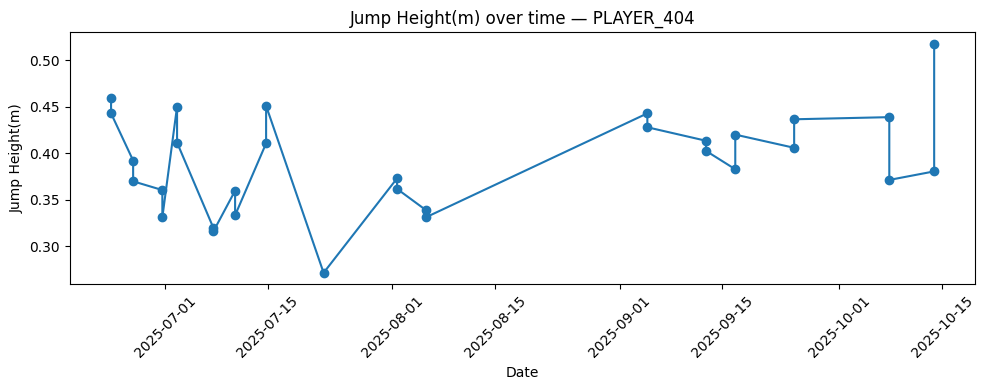

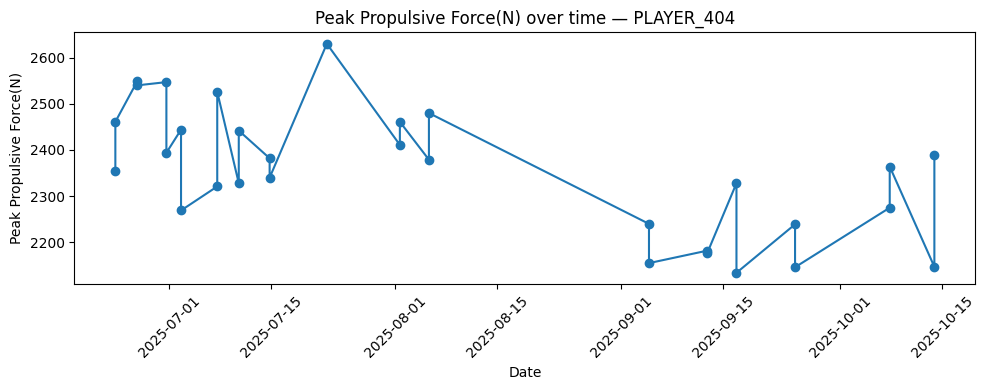

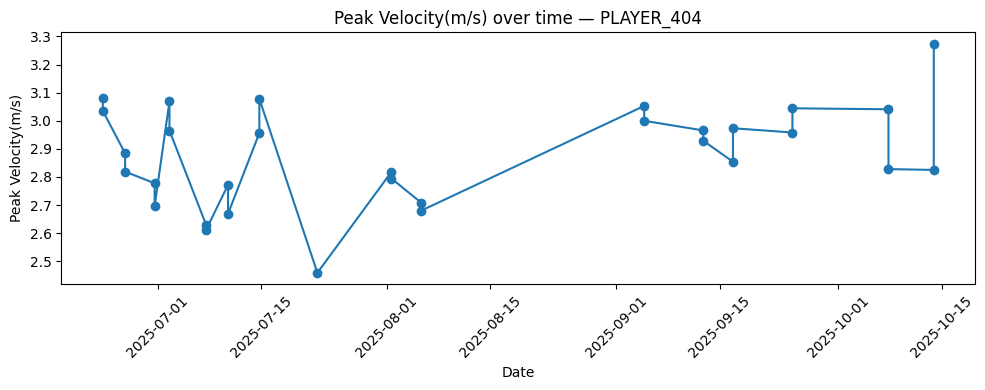

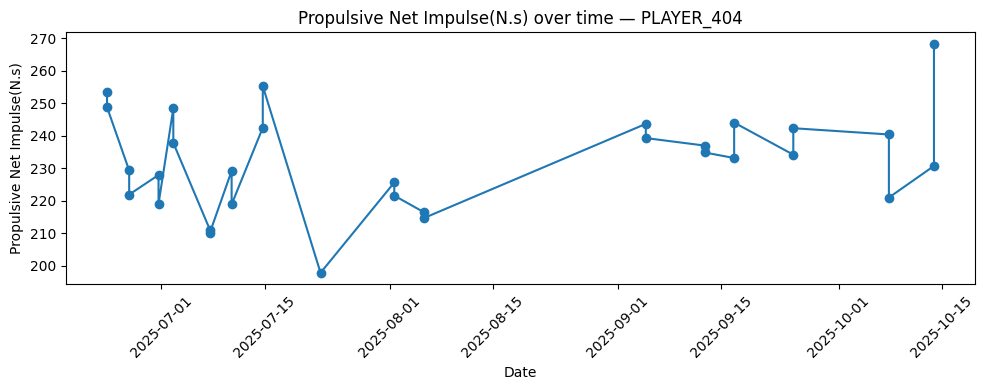

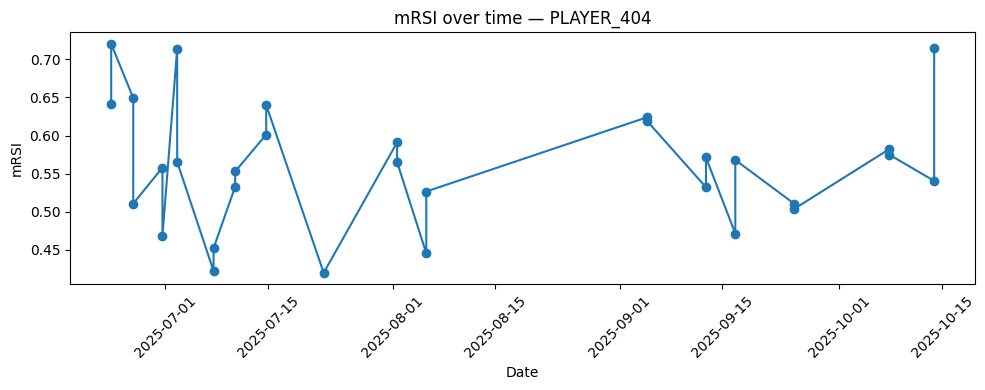

,Metric,Best Value,Best Date,Worst Value,Worst Date,Trend Slope,R,p_value
0,Jump Height(m),0.5179,2025-10-13 22:28:25,0.2713,2025-07-22 14:32:59,0.000442,0.328488,0.071196
1,Peak Propulsive Force(N),2630.0000,2025-07-22 14:32:59,2134.0000,2025-09-16 18:58:37,-2.252692,-0.651119,0.000073
2,Peak Velocity(m/s),3.2737,2025-10-13 22:28:25,2.4593,2025-07-22 14:32:59,0.001526,0.340501,0.060879
3,Propulsive Net Impulse(N.s),268.3646,2025-10-13 22:28:25,197.8147,2025-07-22 14:32:59,0.096051,0.248124,0.178341
4,mRSI,0.7204,2025-06-23 14:19:48,0.4198,2025-07-22 14:32:59,-0.000020,-0.009887,0.957900


In [12]:
summary_404 = plot_athlete_metrics(df_team, "PLAYER_404", selected_metrics, months_back=12)
summary_404


PLAYER_404 demonstrates improvements in jump height, peak velocity, and net impulse, while peak propulsive force has declined significantly and mRSI has remained stable. This pattern may reflect a shift toward more efficient or technical movement strategies, or possible fatigue affecting force production. Overall, PLAYER_404 shows positive trends in explosive performance, but the decline in peak force should be monitored.


1. Jump Height (m)
Best: 0.5179 (2025-10-13)
Worst: 0.2713 (2025-07-22)
Trend: Positive (slope = 0.000442, p = 0.071196)
Interpretation: Jump height has generally increased, suggesting improved explosive power, though the trend is not statistically significant.


2. Peak Propulsive Force (N)
Best: 2630.0 (2025-07-22)
Worst: 2134.0 (2025-09-16)
Trend: Negative (slope = -2.252692, p = 0.000073)
Interpretation: Peak propulsive force has significantly declined, which may indicate fatigue, reduced strength, or a shift toward more efficient movement.


3. Peak Velocity (m/s)
Best: 3.2737 (2025-10-13)
Worst: 2.4593 (2025-07-22)
Trend: Positive (slope = 0.001526, p = 0.060879)
Interpretation: Peak velocity has increased, reflecting faster movement and improved explosive capability, though the trend is just shy of statistical significance.


4. Propulsive Net Impulse (N·s)
Best: 268.36 (2025-10-13)
Worst: 197.81 (2025-07-22)
Trend: Positive (slope = 0.096051, p = 0.178341)
Interpretation: Net impulse shows a mild upward trend, suggesting more consistent or improved force production over time, but this trend is not statistically significant.


5. mRSI
Best: 0.7204 (2025-06-23)
Worst: 0.4198 (2025-07-22)
Trend: Stable (slope = -0.000020, p = 0.957900)
Interpretation: mRSI has remained stable over the year, indicating little change in reactive strength and stretch–shortening cycle efficiency.

